In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile,join
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')
import math
%matplotlib inline

In [2]:
def load_dataset(foldername,filename):
    file = "data/HMP_Dataset/"+foldername+"/"+filename
    data = np.array(pd.read_csv(file,sep=' ',header=None,names=['X','Y','Z']))
    return data


def resize_data_by_factor(segment_length=32,overlap=0,print_Ind=False):
    final_data=np.array([[]])
    folder = ['Brush_teeth','Climb_stairs','Comb_hair','Descend_stairs','Drink_glass','Eat_meat','Eat_soup',
              'Getup_bed','Liedown_bed','Pour_water','Sitdown_chair','Standup_chair','Use_telephone','Walk']
    for folder_name in range(len(folder)):
        #print ("Processing for :{} : {}".format(folder_name,folder[folder_name]))
        num_elements_per_folder=0
        file_folder_name = "data/HMP_Dataset/"+folder[folder_name]
        dir_filename = [f for f in listdir(file_folder_name) if isfile(join(file_folder_name, f))]
        for file_name in range(len(dir_filename)):
            num_elements_per_file=0
            folder_file_extract = [folder_name,folder[folder_name],dir_filename[file_name]]
            data=load_dataset(folder[folder_name],dir_filename[file_name])
            start_idx = 0
            end_idx = start_idx+segment_length
            run_ind=True
            
            while(run_ind):
                #print ("Folder:{} File:{} Total:{}. num:{} Start:{} End:{}".format(folder[folder_name],dir_filename[file_name],data.shape[0],num_elements,start_idx,end_idx))
                data_extract=data[start_idx:end_idx,:].flatten().reshape(1,segment_length*3).astype(int)
                data_append=np.append(data_extract,folder_file_extract).reshape(1,(segment_length*3)+3)
                if (final_data.shape[1] > 0):
                    final_data=np.vstack((final_data,data_append))
                else:
                    final_data=np.vstack(data_append)
                start_idx += int(np.round(segment_length - ((segment_length)*(overlap/100))))
                end_idx = int(np.round(start_idx+segment_length))
                if (end_idx > data.shape[0]):
                    run_ind = False
                num_elements_per_file+=1
                num_elements_per_folder+=1
            #if (print_Ind):
                #print ("Folder:{} File:{} Total:{}. num:{} Start:{} End:{}".format(folder[folder_name],dir_filename[file_name],data.shape[0],num_elements_per_file,start_idx,end_idx))
        if (print_Ind):
            print ("Category:{}:{}   File:{}  Segment:{}".format(folder[folder_name],folder_name,len(dir_filename),num_elements_per_folder))

    if (print_Ind):
        print ("Resize of Data Completed: {}".format(final_data.shape))
    return final_data



def kmeans_prediction(final_data,n_cluster=480,segment_length=32,print_Ind=False):
    i=0
    kmeans_predict_all = np.array([[]])
    kmeans = KMeans(n_clusters=n_cluster).fit(final_data[:,0:segment_length*3].astype(int))
    folder = ['Brush_teeth','Climb_stairs','Comb_hair','Descend_stairs','Drink_glass','Eat_meat','Eat_soup',
              'Getup_bed','Liedown_bed','Pour_water','Sitdown_chair','Standup_chair','Use_telephone','Walk']
    for folder_name in range(len(folder)):
        #print ("Processing for :{} : {}".format(folder_name,folder[folder_name]))
        file_folder_name = "data/HMP_Dataset/"+folder[folder_name]
        dir_filename = [f for f in listdir(file_folder_name) if isfile(join(file_folder_name, f))]
        for file_name in range(len(dir_filename)):
            i+=1
            folder_file_extract = [folder_name,folder[folder_name],dir_filename[file_name]]
            extract_final_data=final_data[(final_data[:,3*segment_length+1] == folder[folder_name]) & (final_data[:,3*segment_length+2] == dir_filename[file_name])][:,0:3*segment_length]
            if (print_Ind):
                print ("Processing Folder:{} File Name:{}  Records:{}".format(folder[folder_name],dir_filename[file_name],extract_final_data.shape))
            kmeans_predict=kmeans.predict(extract_final_data)
            a,b=np.histogram(kmeans_predict,np.arange(n_cluster+1)+1)
            a=a.reshape(1,n_cluster)
            a_append=np.append(a,folder_file_extract).reshape(1,n_cluster+3)

            if (kmeans_predict_all.shape[1] > 0):
                kmeans_predict_all=np.vstack((kmeans_predict_all,a_append))
            else:
                kmeans_predict_all=np.vstack(a_append)
    if (print_Ind):
        print ("KMeans Prediction Completed: {}".format(kmeans_predict_all.shape))
    return kmeans_predict_all



def plot_histogram(Category,data,cluster_centers=480):
    data_mean = np.mean(data,axis=0)
    bin_probability = data_mean/float(data_mean.sum())
    b = np.arange(cluster_centers+1)+1
    bin_middles = (b[1:]+b[:-1])/2
    bin_width = b[1]-b[0]
    #plt.subplots(figsize=(12,8))
    plt.bar(bin_middles, bin_probability, width=bin_width,color='blue')
    plt.title(Category)
    plt.show()

    

def kfold_data(kmeans_predict_all,n_cluster=480,print_Ind=False):
    folder = ['Brush_teeth','Climb_stairs','Comb_hair','Descend_stairs','Drink_glass','Eat_meat','Eat_soup',
                  'Getup_bed','Liedown_bed','Pour_water','Sitdown_chair','Standup_chair','Use_telephone','Walk']
    #folder = ['Brush_teeth']
    kmeans_predict_extract = kmeans_predict_all[:,0:n_cluster+1].astype(int)

    train_data_fold = np.array([[]])
    test_data_fold = np.array([[]])

    kf = KFold(n_splits=3)
    for f in range(len(folder)):
        fold=1
        kmeans_predict_extract_fold=kmeans_predict_extract[kmeans_predict_extract[:,n_cluster] == f]
        for trn_idx,test_idx in kf.split(kmeans_predict_extract_fold):
            if (print_Ind):
                print ("Category:{} Fold:{}  :: {}:{}  ::: ".format(f,fold,trn_idx.shape,test_idx.shape))
            category_trn_repeat = np.repeat(f,trn_idx.shape[0]).reshape(trn_idx.shape[0],1)
            category_test_repeat = np.repeat(f,test_idx.shape[0]).reshape(test_idx.shape[0],1)

            fold_trn_repeat = np.repeat(fold,trn_idx.shape[0]).reshape(trn_idx.shape[0],1)
            fold_test_repeat = np.repeat(fold,test_idx.shape[0]).reshape(test_idx.shape[0],1)

            if (train_data_fold.shape[1]>0):
                train_data_fold=np.vstack((train_data_fold,np.hstack((fold_trn_repeat,kmeans_predict_extract_fold[trn_idx]))))
            else:
                train_data_fold=np.vstack(np.hstack((fold_trn_repeat,kmeans_predict_extract_fold[trn_idx])))

            if (test_data_fold.shape[1]>0):
                test_data_fold=np.vstack((test_data_fold,np.hstack((fold_test_repeat,kmeans_predict_extract_fold[test_idx]))))
            else:
                test_data_fold=np.vstack(np.hstack((fold_test_repeat,kmeans_predict_extract_fold[test_idx])))

            fold+=1
    return train_data_fold,test_data_fold



def predict(trn_fold,tst_fold,cluster=480,no_tree=1000,max_depth=10):
    clf = RandomForestClassifier(n_estimators=no_tree,max_depth=max_depth) #n_estimators = no of tree, max_depth = depth of the tree
    X=trn_fold[:,0:cluster]
    y=trn_fold[:,cluster]
    X_test=tst_fold[:,0:cluster]
    y_true=tst_fold[:,cluster]
    clf.fit(X,y)
    y_pred=clf.predict(X_test)
    conf_mat=confusion_matrix(y_true=y_true, y_pred=y_pred)
    return (np.sum(y_true == y_pred)/y_pred.shape[0])*100,conf_mat



def predict_fold(train_data_fold,test_data_fold,cluster=480,print_Ind=False):
    avg_acc=0
    for fold in range(3):
        trn_fold=train_data_fold[train_data_fold[:,0] == fold+1][:,1:cluster+2]
        tst_fold=test_data_fold[test_data_fold[:,0] == fold+1][:,1:cluster+2]
        acc,conf_mat=predict(trn_fold,tst_fold,cluster=cluster)
        avg_acc+=acc
        if (print_Ind):
            print ("Fold:{} Trn:{}  Test:{}  Accuracy:{}".format(fold,trn_fold.shape,tst_fold.shape,acc))
    avg_acc=(avg_acc/3)
    if (print_Ind):
        print ("Average Accuracy:{}".format(avg_acc/3))
    return avg_acc,conf_mat


def predict_segement_overlap_cluster():
    segment_list = [16,32,64]
    overlap_list = [0,50,70]
    cluster_list = [240,480,780]

    # segment_list = [16]
    # overlap_list = [0]
    # cluster_list = [240]

    labels=['Brush_teeth','Climb_stairs','Comb_hair','Descend_stairs','Drink_glass','Eat_meat','Eat_soup',
            'Getup_bed','Liedown_bed','Pour_water','Sitdown_chair','Standup_chair','Use_telephone','Walk']

    for s in (range(len(segment_list))):
        for o in (range(len(overlap_list))):
            final_data=resize_data_by_factor(segment_length=segment_list[s],overlap=overlap_list[o],print_Ind=True)
            df_final_data=pd.DataFrame(final_data)
            final_data_file_name = "submission/final_data/final_data_"+str(segment_list[s])+"_"+str(overlap_list[o])+".csv"
            df_final_data.to_csv(final_data_file_name,index=False)
            #final_data=np.array(pd.read_csv("final_data.csv")) Comment It out (Only Uncomment for Re-Run)
            for k in range(len(cluster_list)):
                kmeans_predict_all=kmeans_prediction(final_data,n_cluster=cluster_list[k],segment_length=segment_list[s],print_Ind=False)
                train_data_fold,test_data_fold=kfold_data(kmeans_predict_all,n_cluster=cluster_list[k],print_Ind=False)
                average_accuracy,confusion_mat=predict_fold(train_data_fold,test_data_fold,cluster=cluster_list[k],print_Ind=False)
                df_confusion_mat=pd.DataFrame(confusion_mat,columns=labels,index=labels)
                confusion_mat_file_name = "submission/confusion_matrix/confusion_matrix_"+str(overlap_list[k])+"_"+str(cluster_list[o])+"_"+str(segment_list[s])+".html"
                df_confusion_mat.to_html(confusion_mat_file_name,index=True)
                print ("Segment:{}  Overlap%:{}  Cluster:{}  Accuracy:{}  Confusion Matrix:{}".format(segment_list[s],overlap_list[o],cluster_list[k],average_accuracy,confusion_mat_file_name))

def plot_histogram_all_category(file_name,no_cluster):
    labels=['Brush_teeth','Climb_stairs','Comb_hair','Descend_stairs','Drink_glass','Eat_meat','Eat_soup',
            'Getup_bed','Liedown_bed','Pour_water','Sitdown_chair','Standup_chair','Use_telephone','Walk']
    file_name="submission/final_data/"+str(file_name)+".csv"
    final_data=np.array(pd.read_csv(file_name))
    kmeans_predict_all=kmeans_prediction(final_data,n_cluster=no_cluster,segment_length=32,print_Ind=False)
    kmeans_predict_all_hist=kmeans_predict_all[:,0:no_cluster+1].astype(int)
    for i in range(14):
        print ("Processing for i:{}".format(i))
        x=kmeans_predict_all_hist[kmeans_predict_all_hist[:,no_cluster] == i][:,0:no_cluster]
        plot_histogram(Category=labels[i],data=x,cluster_centers=no_cluster)                

predict_segement_overlap_cluster()
#plot_histogram_all_category("submission/final_data/final_data_32_70.csv",240)

Category:Brush_teeth:0   File:12  Segment:1858
Category:Climb_stairs:1   File:102  Segment:2465
Category:Comb_hair:2   File:31  Segment:1455
Category:Descend_stairs:3   File:42  Segment:940
Category:Drink_glass:4   File:100  Segment:2624
Category:Eat_meat:5   File:5  Segment:1950
Category:Eat_soup:6   File:3  Segment:416
Category:Getup_bed:7   File:101  Segment:2816
Category:Liedown_bed:8   File:28  Segment:700
Category:Pour_water:9   File:100  Segment:2561
Category:Sitdown_chair:10   File:100  Segment:1515
Category:Standup_chair:11   File:102  Segment:1538
Category:Use_telephone:12   File:13  Segment:945
Category:Walk:13   File:100  Segment:5719
Resize of Data Completed: (27502, 51)
Segment:16  Overlap%:0  Cluster:240  Accuracy:72.69540889027907  Confusion Matrix:submission/confusion_matrix/confusion_matrix_0_240_16.html
Segment:16  Overlap%:0  Cluster:480  Accuracy:72.01064777468643  Confusion Matrix:submission/confusion_matrix/confusion_matrix_50_240_16.html
Segment:16  Overlap%:0  

Category:Liedown_bed:8   File:28  Segment:317
Category:Pour_water:9   File:100  Segment:1154
Category:Sitdown_chair:10   File:100  Segment:627
Category:Standup_chair:11   File:102  Segment:643
Category:Use_telephone:12   File:13  Segment:457
Category:Walk:13   File:100  Segment:2735
Resize of Data Completed: (12705, 195)
Segment:64  Overlap%:50  Cluster:240  Accuracy:74.97604662265611  Confusion Matrix:submission/confusion_matrix/confusion_matrix_0_480_64.html
Segment:64  Overlap%:50  Cluster:480  Accuracy:70.80412557825592  Confusion Matrix:submission/confusion_matrix/confusion_matrix_50_480_64.html
Segment:64  Overlap%:50  Cluster:780  Accuracy:68.90352249093173  Confusion Matrix:submission/confusion_matrix/confusion_matrix_70_480_64.html
Category:Brush_teeth:0   File:12  Segment:1536
Category:Climb_stairs:1   File:102  Segment:1825
Category:Comb_hair:2   File:31  Segment:1152
Category:Descend_stairs:3   File:42  Segment:689
Category:Drink_glass:4   File:100  Segment:1966
Category:Ea

Processing for i:0


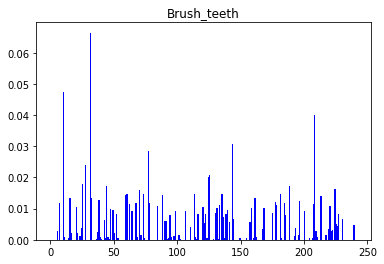

Processing for i:1


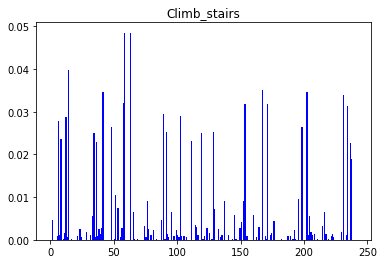

Processing for i:2


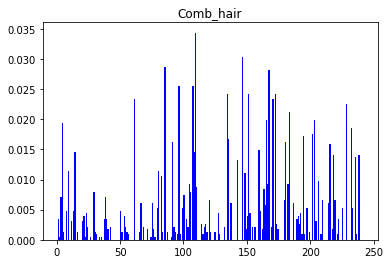

Processing for i:3


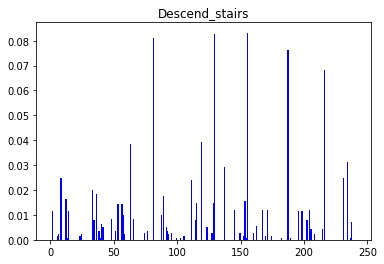

Processing for i:4


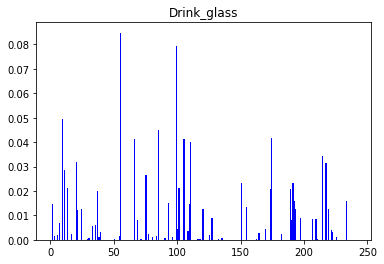

Processing for i:5


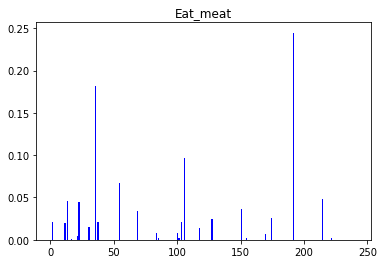

Processing for i:6


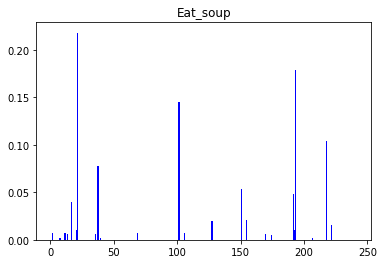

Processing for i:7


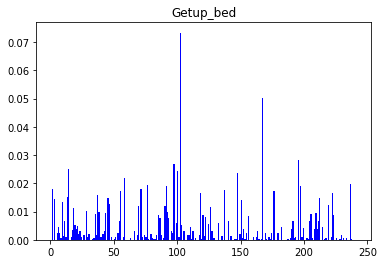

Processing for i:8


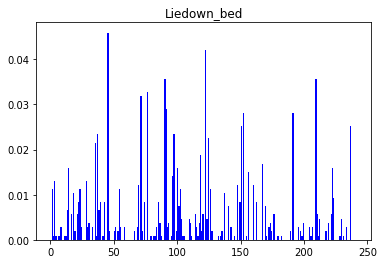

Processing for i:9


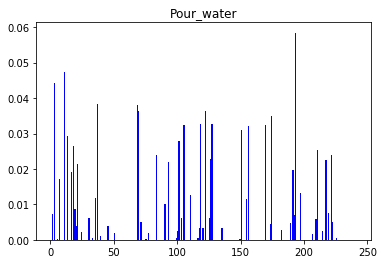

Processing for i:10


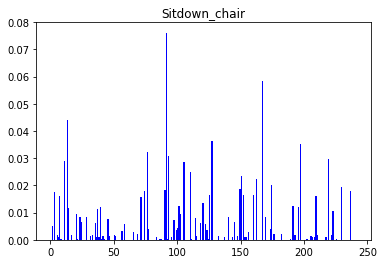

Processing for i:11


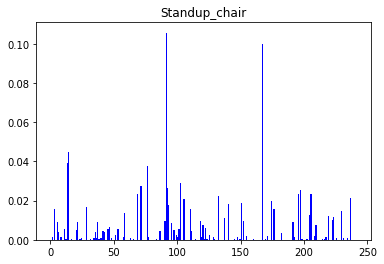

Processing for i:12


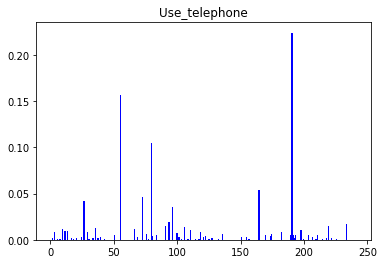

Processing for i:13


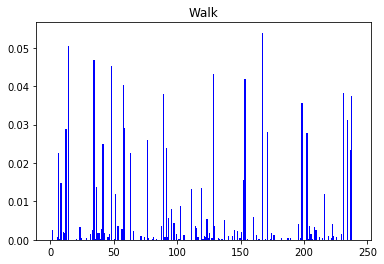

In [5]:
plot_histogram_all_category("final_data_32_70",240)